<a href="https://colab.research.google.com/github/anushkaa-ambuj/Knowledge-Distillation-of-Chest-X-Ray-Images/blob/main/HKD_FashionMNIST-Task%201(i).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Teacher: DenseNet 121 <br>
Student: MobileNet

Dataset: Fashion MNIST</b>

Teacher Acc = 76
Student Acc =

## Import Dependancies

In [ ]:
!pip install torchinfo

## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torchinfo
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.utils import make_grid
#import timer

## Define the device to use

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Transformations

Currently, not utilzing any data transformations

In [ ]:
# Define the transforms for data augmentation
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

## Import the Dataset
### Splitting the Dataset

In [ ]:
# Load the CIFAR-10 dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True,
                                  download=True, transform=transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root='./data', train=False,
                                 download=True, transform=transforms.ToTensor())

In [ ]:
train_data, val_data = torch.utils.data.random_split(train_dataset, [48000, 12000])

## Data Loader

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64,
                                          shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                         shuffle=False)

## Teacher Model

### Initializing the Teacher model

In [ ]:
# Load the pre-trained DenseNet model
teacher = models.densenet121(pretrained=True)

# Change the number of input channels in the first layer to 1
teacher.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Add dropout layers to the classifier
num_ftrs = teacher.classifier.in_features
teacher.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # Add a new fully connected layer
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 10)  # Fashion MNIST has 10 classes
)

teacher.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Teacher Model Summary

In [ ]:
torchinfo.summary(teacher, (1, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
DenseNet                                 [1, 1, 224, 224]          [1, 10]                   --                        --                        --
├─Sequential: 1-1                        [1, 1, 224, 224]          [1, 1024, 14, 14]         --                        --                        --
│    └─Conv2d: 2-1                       [1, 1, 224, 224]          [1, 64, 224, 224]         576                       [3, 3]                    28,901,376
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         [1, 64, 224, 224]         128                       --                        128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         [1, 64, 224, 224]         --                        --                        --
│    └─MaxPool2d: 2-4                    [1, 64, 224, 224]         [1, 64, 112, 112]         -- 

### Train Teacher Model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.001)

In [ ]:
epochs = 35

In [ ]:
train_loss = []; train_acc = []
val_loss = []; val_acc = []

for epoch in range(epochs):
    l1 = []; a1 = []
    l2 = []; a2 = []

    #start = timer()
    for i, (img, labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        output = teacher(img)

        probs = F.softmax(output,dim=1)
        max_prob,preds = torch.max(probs,dim=1)
        acc = (torch.sum(preds == labels).item() / len(preds))
        a1.append(acc)

        loss = criterion(output, labels)
        l1.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    for img, lbl in valloader:
        img = img.to(device)
        lbl = lbl.to(device)
        output = teacher(img)

        loss = criterion(output,lbl)
        l2.append(loss.item())

        probs = F.softmax(output,dim=1)
        max_prob,preds = torch.max(probs,dim=1)
        acc = (torch.sum(preds == lbl).item() / len(preds))
        a2.append(acc)

    train_loss.append(np.mean(l1))
    val_loss.append(np.mean(l2))
    train_acc.append(np.mean(a1))
    val_acc.append(np.mean(a2))

    #end = timer()
    #time = end - start
    #time = time/60

    print(f'Epoch {epoch+1}: Train Loss==> {np.mean(l1):.2f} Train_Acc==> {np.mean(a1)*100 :.3f} % Val Loss==> {np.mean(l2):.2f}  Val_Acc==> {np.mean(a2)*100 :.3f} %')
    #print(f'Epoch {epoch+1}: Train Loss==> {np.mean(train_loss):.2f} Train_Acc==> {np.mean(train_acc)*100 :.3f} % Val Loss==> {np.mean(val_loss):.2f} Val_Acc==> {np.mean(val_acc)*100 :.3f} % Time==> {time:.2f} mins')

Epoch 1: Train Loss==> 1.47 Train_Acc==> 57.908 % Val Loss==> 0.84  Val_Acc==> 75.025 %
Epoch 2: Train Loss==> 0.67 Train_Acc==> 78.252 % Val Loss==> 0.57  Val_Acc==> 80.303 %
Epoch 3: Train Loss==> 0.52 Train_Acc==> 82.046 % Val Loss==> 0.48  Val_Acc==> 83.319 %
Epoch 4: Train Loss==> 0.44 Train_Acc==> 84.925 % Val Loss==> 0.42  Val_Acc==> 85.580 %
Epoch 5: Train Loss==> 0.39 Train_Acc==> 86.533 % Val Loss==> 0.39  Val_Acc==> 86.411 %
Epoch 6: Train Loss==> 0.35 Train_Acc==> 87.644 % Val Loss==> 0.36  Val_Acc==> 87.184 %
Epoch 7: Train Loss==> 0.32 Train_Acc==> 88.640 % Val Loss==> 0.34  Val_Acc==> 88.065 %
Epoch 8: Train Loss==> 0.30 Train_Acc==> 89.531 % Val Loss==> 0.33  Val_Acc==> 88.539 %
Epoch 9: Train Loss==> 0.28 Train_Acc==> 90.237 % Val Loss==> 0.32  Val_Acc==> 88.713 %
Epoch 10: Train Loss==> 0.26 Train_Acc==> 90.900 % Val Loss==> 0.31  Val_Acc==> 88.921 %
Epoch 11: Train Loss==> 0.24 Train_Acc==> 91.490 % Val Loss==> 0.31  Val_Acc==> 89.195 %
Epoch 12: Train Loss==> 0.22 T

KeyboardInterrupt: ignored

### Epoch vs Loss, Epoch vs Accuracy Graphs

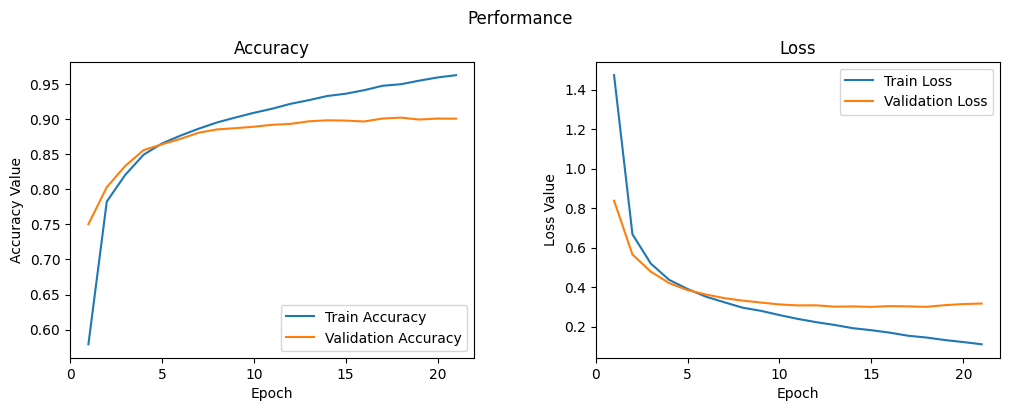

In [ ]:
epochs=21
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))

ax2.plot(epoch_list, train_loss, label='Train Loss')
ax2.plot(epoch_list, val_loss, label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax1.plot(epoch_list, train_acc, label='Train Accuracy')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

### Classification Metrics & Confusion Matrix

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = teacher(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Report: \n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.8914
Confusion Matrix: 
 [[834   2  19  23   1   0 113   0   8   0]
 [  3 973   3  13   2   0   4   0   2   0]
 [ 17   2 845  14  62   0  60   0   0   0]
 [ 24   9  11 893  30   0  30   0   1   2]
 [  1   1  91  30 801   0  73   0   3   0]
 [  0   0   0   2   0 976   0  12   3   7]
 [113   1  71  35  66   0 701   0  13   0]
 [  0   0   0   0   0  16   0 971   0  13]
 [  4   0   4   4   3   3   6   0 974   2]
 [  0   0   0   0   0   7   1  46   0 946]]
Performance Report: 
               precision    recall  f1-score   support

       plane       0.84      0.83      0.84      1000
         car       0.98      0.97      0.98      1000
        bird       0.81      0.84      0.83      1000
         cat       0.88      0.89      0.89      1000
        deer       0.83      0.80      0.82      1000
         dog       0.97      0.98      0.98      1000
        frog       0.71      0.70      0.71      1000
       horse       0.94      0.97      0.96      1000
        ship       0.97

### Save the Model

In [ ]:
# Save the teacher_model
#filename = 'teacher_model.sav'
#pickle.dump(teacher, open(filename, 'wb'))

In [ ]:
torch.save(teacher.state_dict(), 'model_teacher')

## Student Model

### Initializing the model

In [ ]:
# Define the MobileNet architecture
student = models.mobilenet_v2(pretrained=False)
student.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)  # Change input channels to 1
num_ftrs_mobilenet = student.classifier[1].in_features
student.classifier[1] = nn.Linear(num_ftrs_mobilenet, 10)
student.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
torchinfo.summary(student, (1, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2                                        [1, 1, 224, 224]          [1, 10]                   --                        --                        --
├─Sequential: 1-1                                  [1, 1, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─Conv2dNormActivation: 2-1                   [1, 1, 224, 224]          [1, 32, 112, 112]         --                        --                        --
│    │    └─Conv2d: 3-1                            [1, 1, 224, 224]          [1, 32, 112, 112]         288                       [3, 3]                    3,612,672
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         64                        --                        64
│    │    └─ReLU6: 3-3                

### Training the Senior Student model

In [ ]:
# Define the temperature for softening the logits
T = 4

# Define the optimizer for training the MobileNet model
optimizer2 = optim.SGD(student.parameters(), lr=0.001)

In [ ]:
epochs2 = 35

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

# Assuming you have defined the 'senior' and 'teacher' models and initialized them

def train_student(senior, teacher, trainloader, valloader, epochs, T, device, optimizer):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs2):
        l1 = []
        l2 = []
        a1 = []
        a2 = []

        for i, (img, labels) in enumerate(trainloader):
            img = img.to(device)
            labels = labels.to(device)
            output = student(img)

            # Accuracy
            probs = F.softmax(output, dim=1)
            max_prob, preds = torch.max(probs, dim=1)
            acc = (torch.sum(preds == labels).item() / len(preds))
            a1.append(acc)

            # Loss
            compare = teacher(img)
            pdist = F.softmax(compare / T, dim=1)
            soft_loss_teacher = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output / T, dim=1), pdist)
            loss = nn.CrossEntropyLoss()(output, labels)
            loss = 0.4 * loss + 0.6 * soft_loss_teacher
            l1.append(loss.item())

            # Backpropagation
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()

        for img, lbl in valloader:
            img = img.to(device)
            lbl = lbl.to(device)
            output = senior(img)
            loss = nn.CrossEntropyLoss()(output, lbl)
            l2.append(loss.item())
            probs = F.softmax(output, dim=1)
            max_prob, preds = torch.max(probs, dim=1)
            acc = (torch.sum(preds == lbl).item() / len(preds))
            a2.append(acc)

        train_loss.append(np.mean(l1))
        val_loss.append(np.mean(l2))
        train_acc.append(np.mean(a1))
        val_acc.append(np.mean(a2))

        print(f'Epoch {epoch+1}: Train Loss==> {np.mean(l1):.2f} Train_Acc==> {np.mean(a1)*100 :.3f} % Val Loss==> {np.mean(l2):.2f}  Val_Acc==> {np.mean(a2)*100 :.3f} %')

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_student(student, teacher, trainloader, valloader, epochs2, T, device, optimizer2)

Epoch 1: Train Loss==> 1.12 Train_Acc==> 29.712 % Val Loss==> 1.42  Val_Acc==> 49.485 %
Epoch 2: Train Loss==> 0.68 Train_Acc==> 59.527 % Val Loss==> 0.90  Val_Acc==> 66.863 %
Epoch 3: Train Loss==> 0.48 Train_Acc==> 70.977 % Val Loss==> 0.73  Val_Acc==> 73.155 %
Epoch 4: Train Loss==> 0.39 Train_Acc==> 75.658 % Val Loss==> 0.65  Val_Acc==> 76.313 %
Epoch 5: Train Loss==> 0.34 Train_Acc==> 78.423 % Val Loss==> 0.61  Val_Acc==> 78.275 %
Epoch 6: Train Loss==> 0.31 Train_Acc==> 80.023 % Val Loss==> 0.58  Val_Acc==> 79.197 %
Epoch 7: Train Loss==> 0.29 Train_Acc==> 81.227 % Val Loss==> 0.55  Val_Acc==> 80.535 %
Epoch 8: Train Loss==> 0.28 Train_Acc==> 82.148 % Val Loss==> 0.53  Val_Acc==> 81.524 %
Epoch 9: Train Loss==> 0.26 Train_Acc==> 83.010 % Val Loss==> 0.52  Val_Acc==> 81.666 %
Epoch 10: Train Loss==> 0.25 Train_Acc==> 83.769 % Val Loss==> 0.51  Val_Acc==> 81.998 %
Epoch 11: Train Loss==> 0.24 Train_Acc==> 84.252 % Val Loss==> 0.50  Val_Acc==> 82.621 %
Epoch 12: Train Loss==> 0.23 T

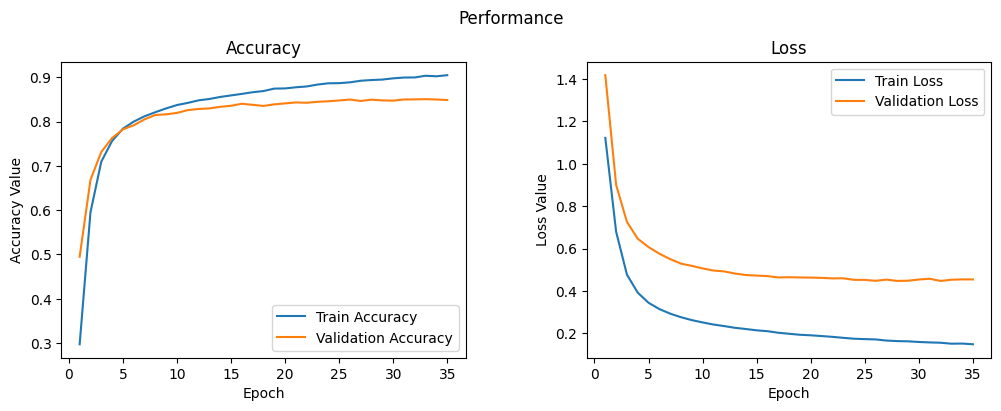

In [ ]:
epochs2=35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs2+1))

ax2.plot(epoch_list, train_loss, label='Train Loss')
ax2.plot(epoch_list, val_loss, label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs2+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax1.plot(epoch_list, train_acc, label='Train Accuracy')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs2+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = student(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Report: \n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.8446
Confusion Matrix: 
 [[804   1  16  36   8   1 126   0   8   0]
 [  3 950   7  27  10   0   2   0   1   0]
 [ 18   1 751  16 115   1  91   0   7   0]
 [ 35   6  13 882  26   0  34   0   3   1]
 [  3   4 114  39 765   0  69   0   6   0]
 [  0   1   0   1   0 944   0  38   2  14]
 [173   1 109  31 112   0 551   0  23   0]
 [  0   0   0   0   0  41   0 917   0  42]
 [  4   0   5   4   7   3  20   6 950   1]
 [  0   0   0   0   0  19   0  48   1 932]]
Performance Report: 
               precision    recall  f1-score   support

       plane       0.77      0.80      0.79      1000
         car       0.99      0.95      0.97      1000
        bird       0.74      0.75      0.75      1000
         cat       0.85      0.88      0.87      1000
        deer       0.73      0.77      0.75      1000
         dog       0.94      0.94      0.94      1000
        frog       0.62      0.55      0.58      1000
       horse       0.91      0.92      0.91      1000
        ship       0.95

In [ ]:
# Save the seniorstudent_model
#filename = 'student_model.sav'
#pickle.dump(student, open(filename, 'wb'))

In [ ]:
torch.save(student.state_dict(), 'model_student')